In [38]:
# Data wrangling
import pandas as pd
import numpy as np
import missingno
from collections import Counter
import random as rnd
from numpy import arange
import itertools

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

# cross validation
from sklearn.model_selection import cross_val_score

import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from scipy import stats
from scipy.stats import norm
import seaborn as sns




sns.color_palette("Paired")
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

## Reading in all the data

In [2]:
df_passengers = pd.read_csv('data/train.csv')



In [3]:
df_predict = pd.read_csv('data/test.csv')


### Quick look at the data

In [4]:
df_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_passengers.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Some notes on data

- PassengerId: A unique index for passenger rows. It starts from 1 for first row and increments by 1 for every new row.
- Survived: refers to whether passenger survived. 1 = survived 0 = not survived.
- Pclass: Ticket class. 1 = First class ticket. 2 = Second class ticket. 3 = Third class 
- Name: Passenger's name. Name also contain title. "Mr" for man. "Mrs" for woman. "Miss" for girl. "Master" for boy.
- Sex: Passenger's gender. Male or Female.
- Age: Passenger's age. 
- SibSp: Number of siblings or spouses travelling with each passenger.
- Parch: Number of parents of children travelling with each passenger.
- Ticket: Ticket number
- Fare: price paid by passenger
- Cabin: Cabin number of the passenger. 
- Embarked: refers to where the passenger boarded: Cherbourg (C) --> Southhanpton (S) --> Queenstown (Q)
![image](img/route.jpeg)

In [6]:
df_passengers.shape

(891, 12)

# EDA of Data

### Check for null / na values in data

In [7]:
df_passengers.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Visualize where the missing / null values are


<AxesSubplot:>

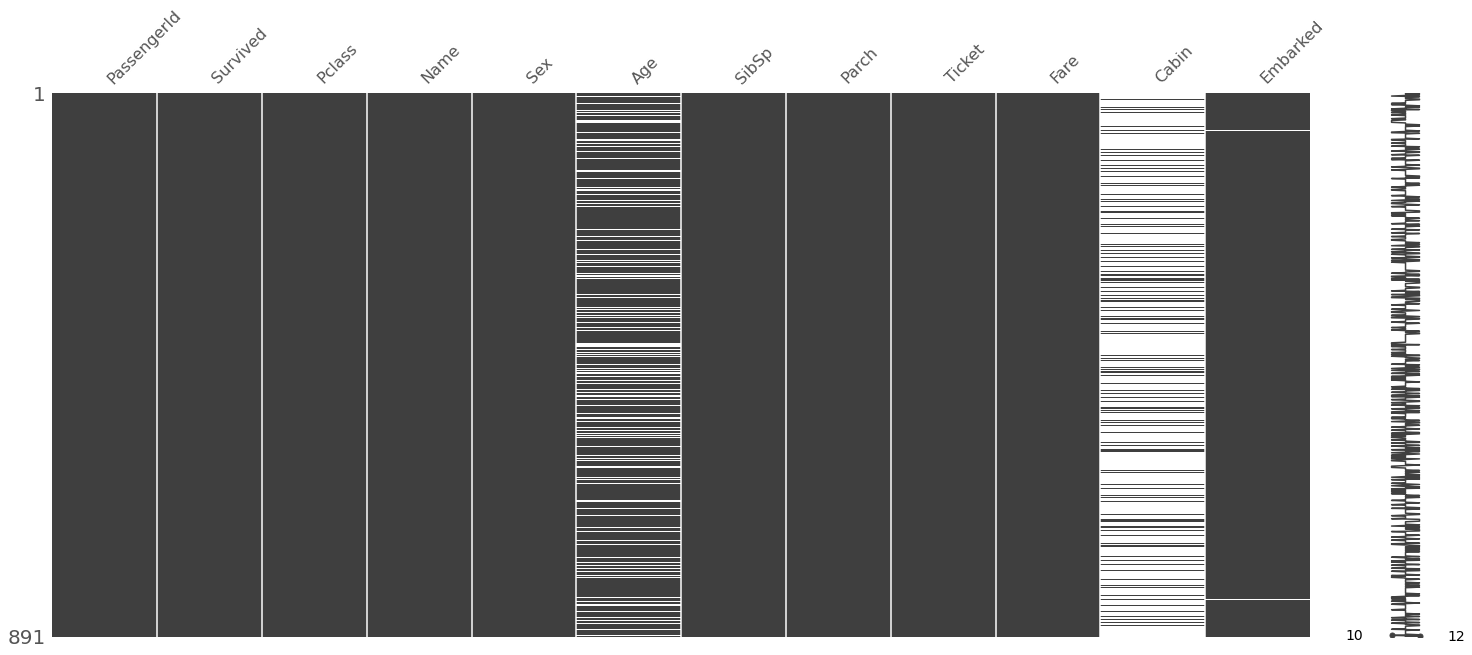

In [8]:
missingno.matrix(df_passengers)

## fill in missing age with dataset average age.

Updated Dataframe:


<AxesSubplot:>

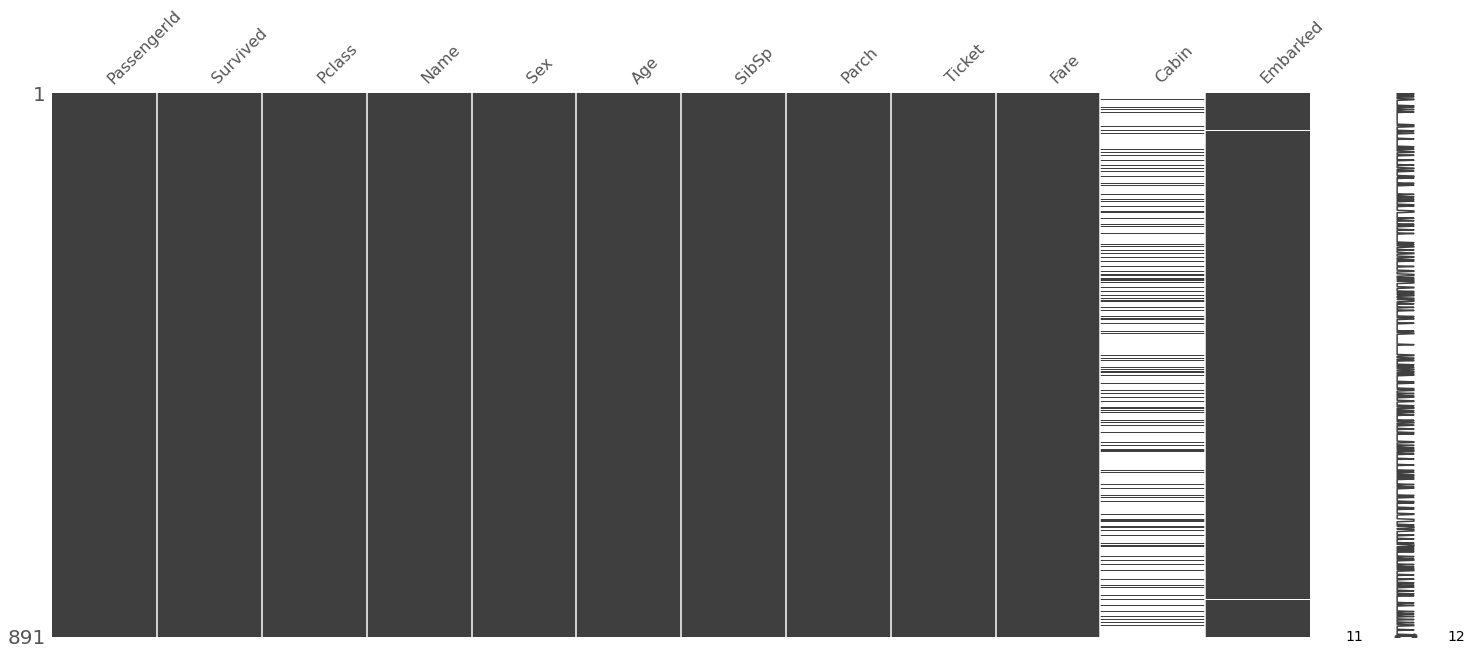

In [9]:

mean_value=df_passengers['Age'].mean()
  
# Replace NaNs in Age column with the
# mean of values in the same column
df_passengers['Age'].fillna(value=mean_value, inplace=True)
print('Updated Dataframe:')
missingno.matrix(df_passengers)

## Drop Cabin from data for now

In [10]:
df_passengers = df_passengers.drop('Cabin', 1)

<AxesSubplot:>

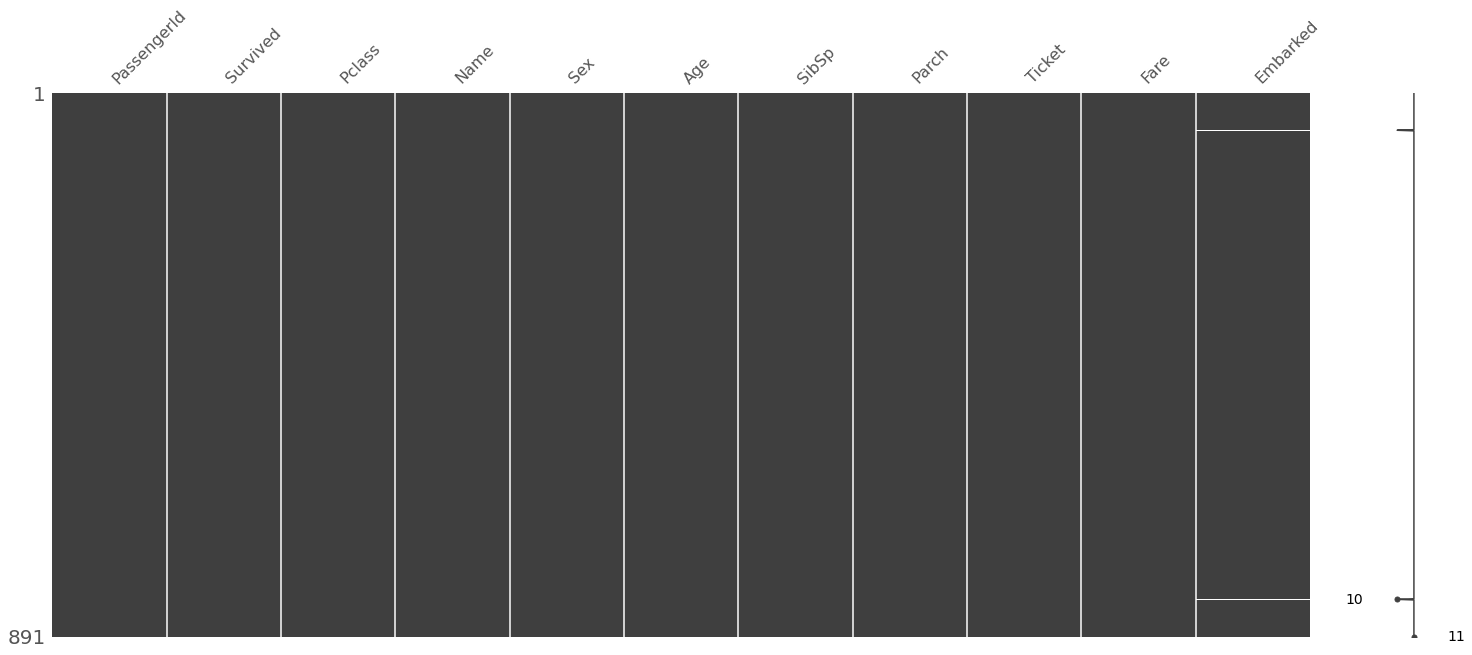

In [11]:
missingno.matrix(df_passengers)

## Identify missing values for embarked

In [12]:
df_passengers[df_passengers.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


### Identify the mode of Embarked in data

In [13]:
embarked_mode = df_passengers['Embarked'].dropna().mode()[0]
embarked_mode

'S'

### Fill missing value in Embarked with embarked_mode

In [14]:
df_passengers['Embarked'].fillna(embarked_mode, inplace = True)

### Check for any remaining Null values

In [15]:
df_passengers.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## simplify Age to 4 groups: Child (0-12), Teen (13-18), Adult (19-65), Senior (66+)

In [16]:

def encodeAge(age):
    conditions = [age < 13,
                  age < 18,
                  age < 65,
                  age < 100 ]

    values = ['Child','Teen','Adult','Senior']
    return np.select(conditions, values, default='Adult') 

df_passengers['AgeGroup'] = df_passengers.Age.apply(encodeAge)



In [17]:
df_passengers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S,Adult
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S,Adult
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S,Adult
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C,Adult


### Look at survival rate by Sex, Age and Pclass

In [18]:

age = pd.cut(df_passengers['Age'], [0, 12, 17, 64, 80])
df_passengers.pivot_table('Survived', ['Sex', age], 'Pclass')

Pclass                  1         2         3
Sex    Age                                   
female (0, 12]   0.000000  1.000000  0.478261
       (12, 17]  1.000000  1.000000  0.666667
       (17, 64]  0.976744  0.906250  0.486239
male   (0, 12]   1.000000  1.000000  0.360000
       (12, 17]  1.000000  0.000000  0.055556
       (17, 64]  0.357143  0.084211  0.122924
       (64, 80]  0.166667  0.000000  0.000000

### Look at survival rate by Sex, Age and Embarked

In [19]:
df_passengers.pivot_table('Survived', ['Sex', age], 'Embarked')

Embarked                C         Q         S
Sex    Age                                   
female (0, 12]   0.857143       NaN  0.520000
       (12, 17]  0.800000  1.000000  0.800000
       (17, 64]  0.892857  0.727273  0.711765
male   (0, 12]   0.750000  0.000000  0.620690
       (12, 17]  0.333333       NaN  0.055556
       (17, 64]  0.294118  0.085714  0.146907
       (64, 80]  0.000000  0.000000  0.166667

## Start Visualizing the Data

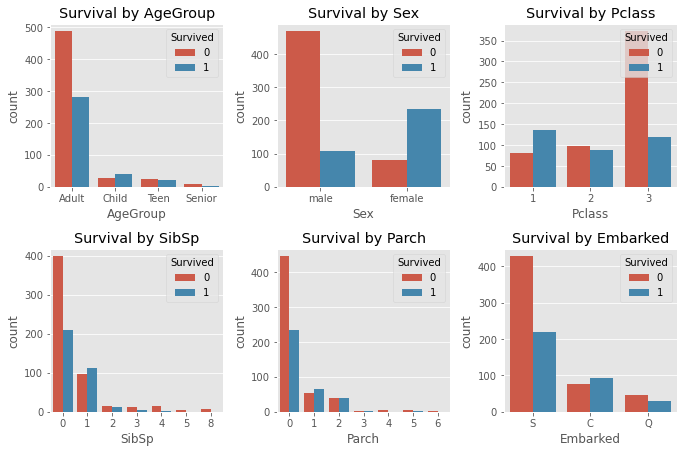

In [20]:

cols = ['AgeGroup', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']

n_rows = 2
n_cols = 3

# The subplot grid and the figure size of each graph
# This returns a Figure (fig) and an Axes Object (axs)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.2,n_rows*3.2))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        
        i = r*n_cols+ c # index to go through the number of columns       
        ax = axs[r][c]  # Show where to position each subplot
        sns.countplot(df_passengers[cols[i]], hue=df_passengers["Survived"], ax=ax)
        ax.set_title(f'Survival by {cols[i]}' )
        ax.legend(title="Survived", loc='upper right') 
        
plt.tight_layout()   

### Plot the survival rate of each class.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

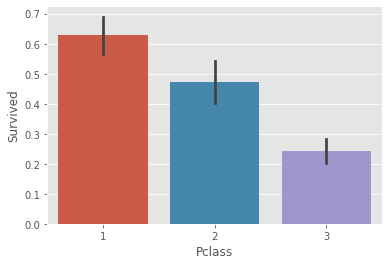

In [21]:

sns.barplot(x='Pclass', y='Survived', data=df_passengers)

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

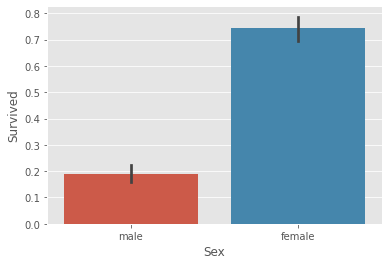

In [22]:
#Plot the survival rate of each Sex.
sns.barplot(x='Sex', y='Survived', data=df_passengers)

### Look at suvival probablity by AgeGroup and Sex

Text(0.5, 1.0, 'Survival Probability by AgeGroup')

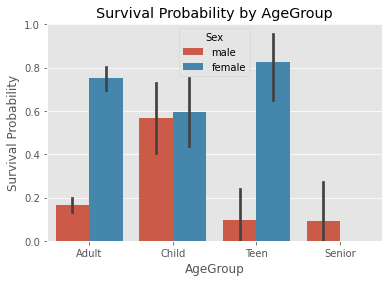

In [23]:
sns.barplot(x = 'AgeGroup', y ='Survived', hue='Sex', data = df_passengers)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by AgeGroup')

### Look at suvival probablity by AgeGroup and Embarked

Text(0.5, 1.0, 'Survival Probability by Embarked')

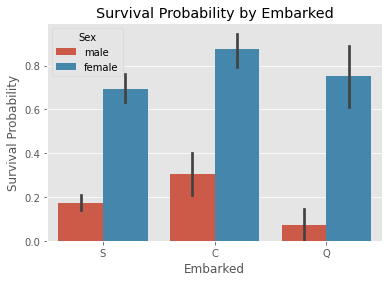

In [24]:
sns.barplot(x = 'Embarked', y ='Survived', hue='Sex', data = df_passengers)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Embarked')

### View distribution of Passengers

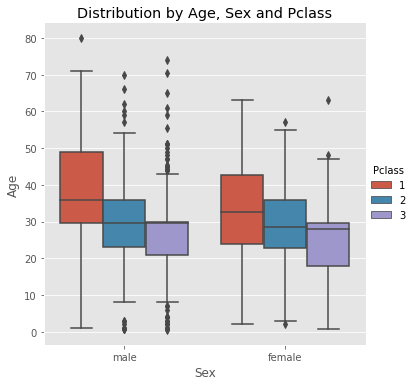

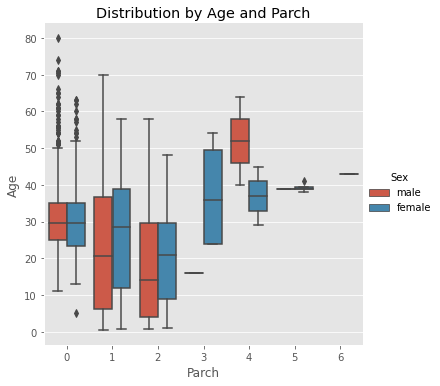

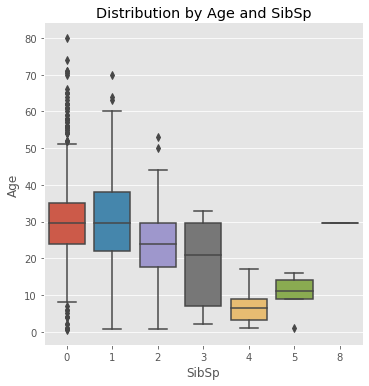

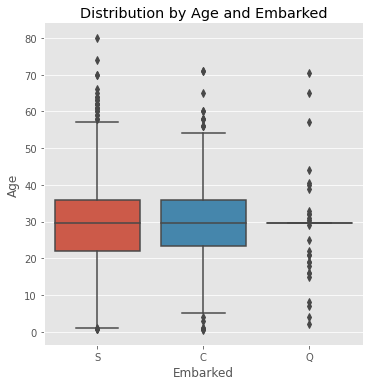

In [25]:

sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = df_passengers).set(title='Distribution by Age, Sex and Pclass')
sns.factorplot(y = 'Age', x = 'Parch', hue='Sex', kind = 'box', data = df_passengers).set(title='Distribution by Age and Parch')
sns.factorplot(y = 'Age', x = 'SibSp', kind = 'box', data = df_passengers).set(title='Distribution by Age and SibSp')
sns.factorplot(y = 'Age', x = 'Embarked', kind = 'box', data = df_passengers).set(title='Distribution by Age and Embarked')


In [26]:
##


## Begin Modeling

In [27]:
# create a copy of the data for modelling
df_modeling = df_passengers.copy()

# create subset of the data that retains only features that will be used in model
df_modeling = df_modeling[['Pclass', 'Sex', 'SibSp','Parch', 'Fare', 'Embarked', 'AgeGroup','Survived']]

In [28]:
## Numerically encode categorical features

def encode_categorical_features(df):
    from sklearn.preprocessing import LabelEncoder
    labelencoder = LabelEncoder()
    
    # Numerically encode Sex
    df.Sex= labelencoder.fit_transform(df.Sex.values)
    
    
    # Numerically encode Embarked
    df.Embarked= labelencoder.fit_transform(df.Embarked.values)
    
    
    # Numerically encode AgeGroup
    df.AgeGroup= labelencoder.fit_transform(df.AgeGroup.values)


### Encode catergorical features

In [29]:
encode_categorical_features(df_modeling)
df_modeling

,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,Survived
0,3,1,1,0,7.2500,2,0,0
1,1,0,1,0,71.2833,0,0,1
2,3,0,0,0,7.9250,2,0,1
3,1,0,1,0,53.1000,2,0,1
4,3,1,0,0,8.0500,2,0,0
...,...,...,...,...,...,...,...,...
886,2,1,0,0,13.0000,2,0,0
887,1,0,0,0,30.0000,2,0,1
888,3,0,1,2,23.4500,2,0,0
889,1,1,0,0,30.0000,0,0,1


### Split the data into train, validation and test sets

In [30]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_modeling, 
                                                                            target = 'Survived',                                                                            
                                                                            train_size=0.6,
                                                                            valid_size=0.2,
                                                                            test_size=0.2)

In [31]:
df_modeling.columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'AgeGroup',
       'Survived'],
      dtype='object')

## Scale Features

In [32]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [46]:
## functionalize model prep

    
def prep_data(df):
    #Split the data into independent 'X' and dependent 'Y' variables
    X = df[['Pclass', 'Sex', 'SibSp','Parch', 'Fare', 'Embarked', 'AgeGroup']].values
    Y = df.Survived.values
    
    # Split the dataset into 80% Training set and 10% Validation and 10% Testing set
    from fast_ml.model_development import train_valid_test_split
    X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, 
                                                                            target = 'Survived',                                                                            
                                                                            train_size=0.6,
                                                                            valid_size=0.2,
                                                                            test_size=0.2)
    
    # Feature Scaling
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    return  X_train, X_test, X_valid, y_train, y_valid, y_test
        
    
    


In [33]:
## Perform data prep
prep_data(df_modeling)

## Create functions to score models

In [34]:
# Functions for scoring models
def accuracy(actuals, preds):
    return np.mean(actuals == preds)

def precision(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fp = np.sum((actuals == 0) & (preds == 1))
    return tp / (tp + fp)

def recall(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fn = np.sum((actuals == 1) & (preds == 0))
    return tp / (tp + fn)

def F1(actuals, preds):
    p, r = precision(actuals, preds), recall(actuals, preds)
    return 2*p*r / (p + r)

## First Model: kNN 

In [39]:
def model_kNN1(X_train,y_train,k):
    clf = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski', p = 2)
    clf.fit(X_train, y_train)
    y_pred_random_forest_training_set = clf.predict(X_train)
    acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
    print ("Accuracy: %i %% \n"%acc_random_forest)
    
    class_names = ['Survived', 'Not Survived']
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_pred_random_forest_training_set)
    np.set_printoptions(precision=2)
    
    print ('Confusion Matrix in Numbers')
    print (cnf_matrix)
    print ('')
    
    cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    
    print ('Confusion Matrix in Percentage')
    print (cnf_matrix_percent)
    print ('')
    
    ### -- scoring
    knnacc_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    knnpre_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
    knnrecall_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
    knnf1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    # print all 5 times scores 
    print(f'accuracy scores:  {knnacc_scores}')
    print(f'Precision scores: {knnpre_scores}')
    print(f'Recall scores:    {knnrecall_scores}')
    print(f'F1 scores:        {knnf1_scores}')
    print('--------------------------------------')
    # average the scores to get a more accurate score
    print(f'Accuracy after 5 Folds:  {knnacc_scores.mean()}')
    print(f'Precision after 5 Folds: {knnpre_scores.mean()}')
    print(f'Recall after 5 Folds:    {knnrecall_scores.mean()}')
    print(f'F1 after 5 Folds:        {knnf1_scores.mean()}')    
    print(' ')
    ### -- end scoring
    print('---------------------')      
    
    true_class_names = ['True Survived', 'True Not Survived']
    predicted_class_names = ['Predicted Survived', 'Predicted Not Survived']
    
    df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                                 index = true_class_names,
                                 columns = predicted_class_names)
    
    df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                         index = true_class_names,
                                         columns = predicted_class_names)
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(121)
    sns.heatmap(df_cnf_matrix, annot=True, fmt='d')
    
    plt.subplot(122)
    sns.heatmap(df_cnf_matrix_percent, annot=True)

## Run kNN on Training data, then cross-validate with K-fold

Accuracy: 86 % 

Confusion Matrix in Numbers
[[312  31]
 [ 43 148]]

Confusion Matrix in Percentage
[[0.91 0.09]
 [0.23 0.77]]

accuracy scores:  [0.79 0.8  0.78 0.81 0.83]
Precision scores: [0.68 0.71 0.75 0.77 0.78]
Recall scores:    [0.74 0.76 0.55 0.69 0.74]
F1 scores:        [0.71 0.73 0.64 0.73 0.76]
--------------------------------------
Accuracy after 5 Folds:  0.8015517545406453
Precision after 5 Folds: 0.7378900503290746
Recall after 5 Folds:    0.6963562753036437
F1 after 5 Folds:        0.7131776195067334
 
---------------------


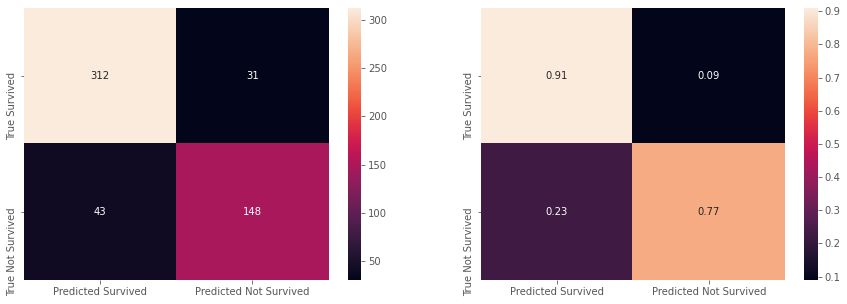

In [40]:
model_kNN1(X_train,y_train,5) #k=5 is the default value.

## Tune kNN by using k values from 3-15

In [43]:
def tune_knn(X_train,y_train):
    #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
    from sklearn.neighbors import KNeighborsClassifier    
    scores_dict = {}
    scores_df = pd.DataFrame()
    k_lst = []
    acc_lst = []
    score_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    for n in range(3,16,1):
 
        knn = KNeighborsClassifier(n_neighbors = n, metric = 'minkowski', p = 2)
        knn.fit(X_train, y_train)
        
        k_lst.append(n)
        score_lst.append(knn.score(X_train, y_train))
        acc_lst.append(accuracy(y_test, knn.predict(X_test)) )
        precision_lst.append(precision(y_test, knn.predict(X_test)))
        recall_lst.append(recall(y_test, knn.predict(X_test)))
        f1_lst.append( F1(y_test, knn.predict(X_test))  )
  
        #scores_df.append(scores_dict,ignore_index=True)
    # dictionary of lists 
    dict = {'K': k_lst, 
            'Score': score_lst,
            'Accuracy': acc_lst,
            'Precision':precision_lst,
            'Recall': recall_lst,
            'F1': f1_lst}  
    df_knn = pd.DataFrame(dict) 
    df_knn.sort_values(by='Accuracy', ascending = False, inplace=True)
    return df_knn

In [56]:
knn_results = tune_knn(X_train,y_train)
knn_results.style.format('{:.2f}')\
            .highlight_max(color = 'lightgreen', axis = 0)\
            .highlight_min(color = 'coral', axis = 0)
            

,K,Score,Accuracy,Precision,Recall,F1
0,3.00,0.87,0.84,0.90,0.70,0.79
2,5.00,0.86,0.82,0.85,0.68,0.76
11,14.00,0.83,0.81,0.92,0.61,0.73
12,15.00,0.82,0.81,0.88,0.64,0.74
1,4.00,0.87,0.80,0.92,0.59,0.72
9,12.00,0.84,0.80,0.90,0.61,0.72
4,7.00,0.84,0.80,0.86,0.63,0.73
5,8.00,0.84,0.80,0.92,0.58,0.71
10,13.00,0.83,0.80,0.86,0.63,0.73
7,10.00,0.84,0.79,0.90,0.58,0.70


## Let's visualize the results

In [60]:
import altair as alt


source = knn_results
alt.Chart(source).mark_trail().encode(
    y='Score',
    x='K',
    size='Precision'
)
base = alt.Chart(source).encode(
        alt.X('K')
)

line_M = base.mark_line(color='red').encode(
    alt.Y('Score:Q', axis=alt.Axis(titleColor='#5276B7'),title='Score')
)

line_A = base.mark_line(color='lightblue').encode(
    alt.Y('Accuracy:Q', axis=alt.Axis(titleColor='#5276A7'),title='Accuracy')
)

line_B = base.mark_line(color='darkblue').encode(
    alt.Y('Precision:Q', axis=alt.Axis(titleColor='#A18727'),title='Precision')
)

line_C = base.mark_line(color='green').encode(
    alt.Y('Recall:Q', axis=alt.Axis(titleColor='#F11111'),title='Recall')
)

line_D = base.mark_line(color='purple').encode(
    alt.Y('F1:Q', axis=alt.Axis(titleColor='#OOOFFF'),title='F1')
)

alt.layer(line_M,line_A, line_B, line_C, line_D)#.resolve_scale(y='independent')

alt.LayerChart(...)

## Ideal k value is 3

Accuracy: 87 % 

Confusion Matrix in Numbers
[[316  27]
 [ 42 149]]

Confusion Matrix in Percentage
[[0.92 0.08]
 [0.22 0.78]]

accuracy scores:  [0.81 0.81 0.85 0.83 0.79]
Precision scores: [0.74 0.72 0.84 0.78 0.69]
Recall scores:    [0.74 0.76 0.71 0.74 0.76]
F1 scores:        [0.74 0.74 0.77 0.76 0.72]
--------------------------------------
Accuracy after 5 Folds:  0.8201728090283901
Precision after 5 Folds: 0.7559704159046264
Recall after 5 Folds:    0.7434547908232119
F1 after 5 Folds:        0.748003663003663
 
---------------------


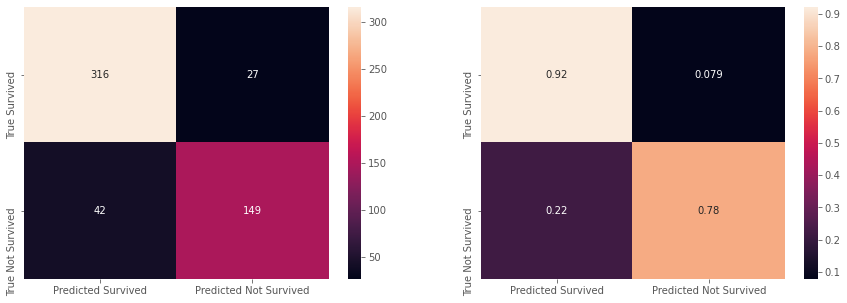

In [57]:
model_kNN1(X_train,y_train,3) #k=3 is the optimised value.

## Lets run model against validation data

Accuracy: 84 % 

Confusion Matrix in Numbers
[[93 10]
 [17 58]]

Confusion Matrix in Percentage
[[0.9  0.1 ]
 [0.23 0.77]]

accuracy scores:  [0.78 0.78 0.64 0.54 0.74]
Precision scores: [0.73 0.89 0.56 0.47 0.67]
Recall scores:    [0.73 0.53 0.6  0.53 0.8 ]
F1 scores:        [0.73 0.67 0.58 0.5  0.73]
--------------------------------------
Accuracy after 5 Folds:  0.696031746031746
Precision after 5 Folds: 0.6643954248366013
Recall after 5 Folds:    0.64
F1 after 5 Folds:        0.6415835777126099
 
---------------------


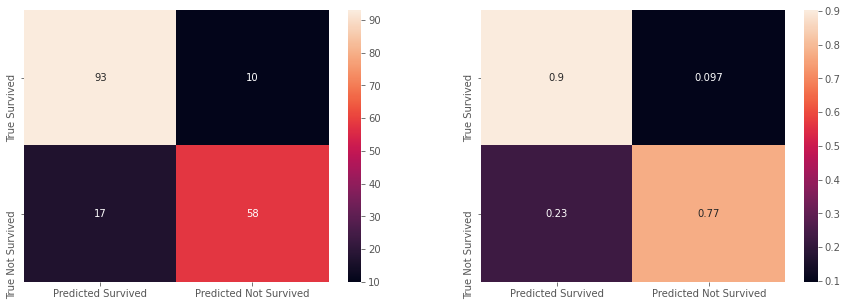

In [58]:

model_kNN1(X_valid,y_valid,3) #k=3 is the optimised value.

## Lets run model against test data using k=3

Accuracy: 87 % 

Confusion Matrix in Numbers
[[93 10]
 [12 64]]

Confusion Matrix in Percentage
[[0.9  0.1 ]
 [0.16 0.84]]

accuracy scores:  [0.83 0.69 0.67 0.81 0.83]
Precision scores: [0.75 0.61 0.58 0.79 0.85]
Recall scores:    [0.94 0.73 0.73 0.73 0.73]
F1 scores:        [0.83 0.67 0.65 0.76 0.79]
--------------------------------------
Accuracy after 5 Folds:  0.7657142857142858
Precision after 5 Folds: 0.7143853222800591
Recall after 5 Folds:    0.7741666666666667
F1 after 5 Folds:        0.7382787597797739
 
---------------------


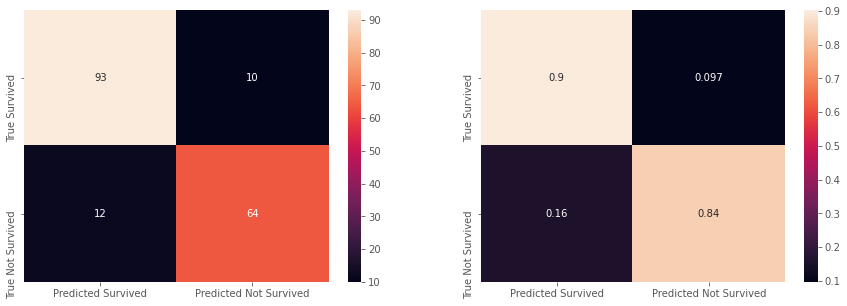

In [59]:

model_kNN1(X_test,y_test,3) #k=3 is the optimised value.

## Second Model: AdaBoost 

In [62]:
def model_AdaBoost(X_train, y_train,m,ne,lr):
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=m),n_estimators = ne,learning_rate=lr)  
    clf.fit(X_train, y_train)
    y_pred_random_forest_training_set = clf.predict(X_train)
    acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
    print ("Accuracy: %i %% \n"%acc_random_forest)
    
    class_names = ['Survived', 'Not Survived']
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_pred_random_forest_training_set)
    np.set_printoptions(precision=2)
    
    print ('Confusion Matrix in Numbers')
    print (cnf_matrix)
    print ('')
    
    cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    
    print ('Confusion Matrix in Percentage')
    print (cnf_matrix_percent)
    print ('')
    
    ### -- scoring
    adaacc_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    adapre_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
    adarecall_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
    adaf1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    # print all 5 times scores 
    print(f'accuracy scores:  {adaacc_scores}')
    print(f'Precision scores: {adapre_scores}')
    print(f'Recall scores:    {adarecall_scores}')
    print(f'F1 scores:        {adaf1_scores}')
    print('--------------------------------------')
    # average the scores to get a more accurate score
    print(f'Accuracy after 5 Folds:  {adaacc_scores.mean()}')
    print(f'Precision after 5 Folds: {adapre_scores.mean()}')
    print(f'Recall after 5 Folds:    {adarecall_scores.mean()}')
    print(f'F1 after 5 Folds:        {adaf1_scores.mean()}')    
    print(' ')
    ### -- end scoring
    print('---------------------')      
    
    true_class_names = ['True Survived', 'True Not Survived']
    predicted_class_names = ['Predicted Survived', 'Predicted Not Survived']
    
    df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                                 index = true_class_names,
                                 columns = predicted_class_names)
    
    df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                         index = true_class_names,
                                         columns = predicted_class_names)
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(121)
    sns.heatmap(df_cnf_matrix, annot=True, fmt='d')
    
    plt.subplot(122)
    sns.heatmap(df_cnf_matrix_percent, annot=True)

## Run the model on Training data using default values for hyperparameters

Accuracy: 83 % 

Confusion Matrix in Numbers
[[304  39]
 [ 47 144]]

Confusion Matrix in Percentage
[[0.89 0.11]
 [0.25 0.75]]

accuracy scores:  [0.79 0.83 0.78 0.82 0.75]
Precision scores: [0.71 0.76 0.73 0.76 0.65]
Recall scores:    [0.66 0.76 0.58 0.74 0.68]
F1 scores:        [0.68 0.76 0.65 0.75 0.67]
--------------------------------------
Accuracy after 5 Folds:  0.7939340504320226
Precision after 5 Folds: 0.7247869674185463
Recall after 5 Folds:    0.6855600539811066
F1 after 5 Folds:        0.7030123290057977
 
---------------------


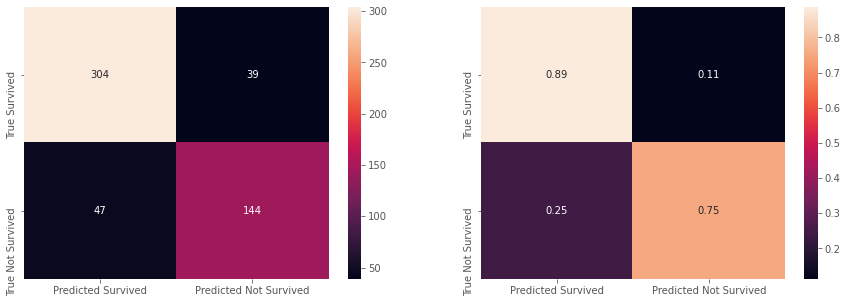

In [63]:
model_AdaBoost(X_train, y_train,1,50,1)

## Fine Tuning Model with Hyperparameters n_esitmators, learning_rate and max_depth

In [ ]:
def tune_ada_estimators(X_train,y_train):
    from sklearn.ensemble import AdaBoostClassifier
    
    
    
    scores_dict = {}
    scores_df = pd.DataFrame()
    n_esti = []
    acc_lst = []
    score_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    for n in range(50,900,50):
 
        adaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=n)
        adaBoost.fit(X_train, y_train)
        ### -- scoring
        adaacc_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='accuracy')
        adapre_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='precision')
        adarecall_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='recall')
        adaf1_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='f1')
    
        n_esti.append(n)
        score_lst.append(adaBoost.score(X_train, y_train))
        acc_lst.append(adaacc_scores.mean())
        precision_lst.append(adapre_scores.mean())
        recall_lst.append(adarecall_scores.mean())
        f1_lst.append( adaf1_scores.mean() )
  
        #scores_df.append(scores_dict,ignore_index=True)
    # dictionary of lists 
    dict = {'n_estimators': n_esti, 
            'Score': score_lst,
            'Accuracy': acc_lst,
            'Precision':precision_lst,
            'Recall': recall_lst,
            'F1': f1_lst}  
    df_ada = pd.DataFrame(dict) 
    df_ada.sort_values(by='Score', ascending = False, inplace=True)
    return df_ada

def tune_ada_learners(X_train,y_train,estimators):
    from sklearn.ensemble import AdaBoostClassifier
    
    
    
    scores_dict = {}
    scores_df = pd.DataFrame()
    leaners = []
    acc_lst = []
    score_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    for n in range(1,11,1):
 
        adaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=n), n_estimators=estimators)
        adaBoost.fit(X_train, y_train)
        
        leaners.append(n)
        ### -- scoring
        adaacc_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='accuracy')
        adapre_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='precision')
        adarecall_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='recall')
        adaf1_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='f1')
    

        score_lst.append(adaBoost.score(X_train, y_train))
        acc_lst.append(adaacc_scores.mean())
        precision_lst.append(adapre_scores.mean())
        recall_lst.append(adarecall_scores.mean())
        f1_lst.append( adaf1_scores.mean() )
  
        #scores_df.append(scores_dict,ignore_index=True)
    # dictionary of lists 
    dict = {'Learners':leaners,
            'Score': score_lst,
            'Accuracy': acc_lst,
            'Precision':precision_lst,
            'Recall': recall_lst,
            'F1': f1_lst}   
    df_ada_learn = pd.DataFrame(dict) 
    df_ada_learn.sort_values(by='Score', ascending = False, inplace=True)
    return df_ada_learn

def tune_ada_learn_rate(X_train,y_train,estimators,learners):
    from sklearn.ensemble import AdaBoostClassifier
    
    
    
    scores_dict = {}
    scores_df = pd.DataFrame()
    learn_rate = []
    acc_lst = []
    score_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    for n in arange(0.1, 2.1, 0.1):
 
        adaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=learners), 
                                      n_estimators=estimators,
                                     learning_rate=n)
        adaBoost.fit(X_train, y_train)
        
        learn_rate.append(n)
        ### -- scoring
        adaacc_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='accuracy')
        adapre_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='precision')
        adarecall_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='recall')
        adaf1_scores = cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='f1')
    
   
        score_lst.append(adaBoost.score(X_train, y_train))
        acc_lst.append(adaacc_scores.mean())
        precision_lst.append(adapre_scores.mean())
        recall_lst.append(adarecall_scores.mean())
        f1_lst.append( adaf1_scores.mean() )
  
  
        #scores_df.append(scores_dict,ignore_index=True)
    # dictionary of lists 
    dict = {'Learn_Rate': learn_rate, 
            'Score': score_lst,
            'Accuracy': acc_lst,
            'Precision':precision_lst,
            'Recall': recall_lst,
            'F1': f1_lst}  
    df_ada_learn_rate = pd.DataFrame(dict) 
    df_ada_learn_rate.sort_values(by='Score', ascending = False, inplace=True)
    return df_ada_learn_rate

In [143]:
ada_results = tune_ada_estimators(X_train,y_train)

ada_results.style\
      .format('{:.2f}')\
      .highlight_max(color = 'lightgreen')\
      .highlight_min(color = 'coral')\
      .highlight_null(null_color='yellow')

,n_estimators,Score,Accuracy,Precision,Recall,F1
16,850.00,0.90,0.80,0.73,0.72,0.72
9,500.00,0.89,0.81,0.74,0.71,0.72
15,800.00,0.89,0.80,0.73,0.71,0.72
13,700.00,0.89,0.80,0.73,0.71,0.72
14,750.00,0.89,0.80,0.73,0.72,0.72
12,650.00,0.89,0.81,0.74,0.73,0.73
11,600.00,0.89,0.81,0.75,0.73,0.73
10,550.00,0.89,0.81,0.74,0.73,0.73
8,450.00,0.88,0.81,0.74,0.72,0.73
7,400.00,0.88,0.80,0.74,0.70,0.71


In [126]:
ada_results2 = tune_ada_learners(X_train,y_train,150)

ada_results2.style\
      .format('{:.2f}')\
      .highlight_max(color = 'lightgreen')\
      .highlight_min(color = 'coral')\
      .highlight_null(null_color='yellow')

,Learners,Score,Accuracy,Precision,Recall,F1
1,2.00,0.95,0.77,0.70,0.69,0.69
2,3.00,0.95,0.77,0.74,0.67,0.67
3,4.00,0.95,0.79,0.72,0.66,0.67
4,5.00,0.95,0.78,0.73,0.66,0.69
5,6.00,0.95,0.78,0.69,0.68,0.70
6,7.00,0.95,0.79,0.73,0.65,0.70
7,8.00,0.95,0.78,0.75,0.68,0.69
8,9.00,0.95,0.78,0.73,0.66,0.69
9,10.00,0.95,0.78,0.71,0.66,0.68
0,1.00,0.89,0.81,0.75,0.73,0.73


In [132]:
import altair as alt


source = ada_results2

alt.Chart(source).mark_trail().encode(
    y='Score',
    x='Learners',
    size='Precision'

)

base = alt.Chart(source).encode(
        alt.X('Learners')
)

line_M = base.mark_line(color='red').encode(
    alt.Y('Score:Q', axis=alt.Axis(titleColor='#5276B7'),title='Score')
)

line_A = base.mark_line(color='lightblue').encode(
    alt.Y('Accuracy:Q', axis=alt.Axis(titleColor='#5276A7'),title='Accuracy')
)

line_B = base.mark_line(color='darkblue').encode(
    alt.Y('Precision:Q', axis=alt.Axis(titleColor='#A18727'),title='Precision')
)

line_C = base.mark_line(color='green').encode(
    alt.Y('Recall:Q', axis=alt.Axis(titleColor='#F11111'),title='Recall')
)

line_D = base.mark_line(color='purple').encode(
    alt.Y('F1:Q', axis=alt.Axis(titleColor='#OOOFFF'),title='F1')
)

alt.layer(line_M,line_A, line_B, line_C, line_D)#.resolve_scale(y='independent')


alt.LayerChart(...)

In [127]:
ada_results3 = tune_ada_learn_rate(X_train,y_train,600,1)

ada_results3.style\
      .format('{:.2f}')\
      .highlight_max(color = 'lightgreen')\
      .highlight_min(color = 'coral')\
      .highlight_null(null_color='yellow')

,Learn_Rate,Score,Accuracy,Precision,Recall,F1
18,1.90,0.93,0.77,0.70,0.65,0.67
17,1.80,0.93,0.76,0.68,0.65,0.67
16,1.70,0.92,0.78,0.70,0.68,0.69
14,1.50,0.91,0.78,0.71,0.68,0.69
15,1.60,0.91,0.78,0.71,0.68,0.69
13,1.40,0.91,0.78,0.70,0.69,0.69
12,1.30,0.90,0.79,0.72,0.69,0.70
11,1.20,0.90,0.80,0.73,0.72,0.72
10,1.10,0.89,0.81,0.74,0.72,0.72
9,1.00,0.89,0.81,0.75,0.73,0.73


In [133]:
import altair as alt


source = ada_results3

alt.Chart(source).mark_trail().encode(
    y='Score',
    x='Learn_Rate',
    size='Precision'

)

base = alt.Chart(source).encode(
        alt.X('Learn_Rate')
)

line_M = base.mark_line(color='red').encode(
    alt.Y('Score:Q', axis=alt.Axis(titleColor='#5276B7'),title='Score')
)

line_A = base.mark_line(color='lightblue').encode(
    alt.Y('Accuracy:Q', axis=alt.Axis(titleColor='#5276A7'),title='Accuracy')
)

line_B = base.mark_line(color='darkblue').encode(
    alt.Y('Precision:Q', axis=alt.Axis(titleColor='#A18727'),title='Precision')
)

line_C = base.mark_line(color='green').encode(
    alt.Y('Recall:Q', axis=alt.Axis(titleColor='#F11111'),title='Recall')
)

line_D = base.mark_line(color='purple').encode(
    alt.Y('F1:Q', axis=alt.Axis(titleColor='#OOOFFF'),title='F1')
)

alt.layer(line_M,line_A, line_B, line_C, line_D)#.resolve_scale(y='independent')


alt.LayerChart(...)

### best model with ADA on training data: 
- n_estimators = 600
- Learners = 1
- learn rate = 1.9

## Run the model on Training data using optimized values for hyperparameters


Accuracy: 88 % 

Confusion Matrix in Numbers
[[322  21]
 [ 38 153]]

Confusion Matrix in Percentage
[[0.94 0.06]
 [0.2  0.8 ]]

accuracy scores:  [0.8  0.82 0.81 0.83 0.79]
Precision scores: [0.73 0.72 0.8  0.78 0.7 ]
Recall scores:    [0.71 0.82 0.63 0.74 0.74]
F1 scores:        [0.72 0.77 0.71 0.76 0.72]
--------------------------------------
Accuracy after 5 Folds:  0.8126961735143714
Precision after 5 Folds: 0.7468887492143306
Recall after 5 Folds:    0.7276653171390014
F1 after 5 Folds:        0.7344842128784338
 
---------------------


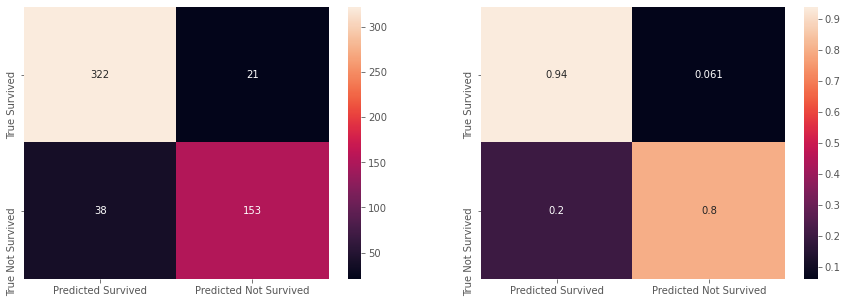

In [186]:
model_AdaBoost(X_train, y_train,1,600,1)

## Run the model on Validation data using optimized values for hyperparameters


Accuracy: 92 % 

Confusion Matrix in Numbers
[[98  5]
 [ 9 66]]

Confusion Matrix in Percentage
[[0.95 0.05]
 [0.12 0.88]]

accuracy scores:  [0.69 0.58 0.61 0.66 0.71]
Precision scores: [0.62 0.5  0.53 0.6  0.65]
Recall scores:    [0.67 0.4  0.6  0.6  0.73]
F1 scores:        [0.65 0.44 0.56 0.6  0.69]
--------------------------------------
Accuracy after 5 Folds:  0.652063492063492
Precision after 5 Folds: 0.5802941176470588
Recall after 5 Folds:    0.6
F1 after 5 Folds:        0.587921146953405
 
---------------------


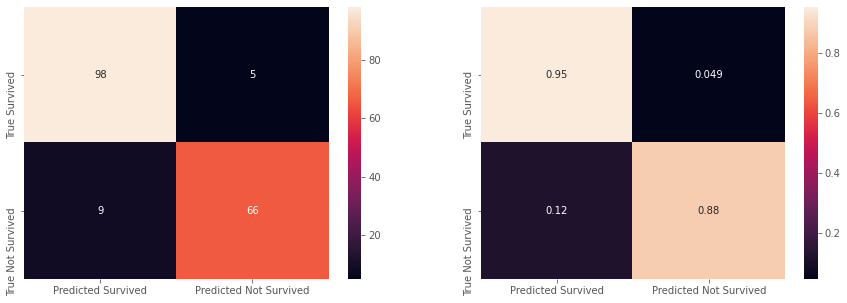

In [188]:
model_AdaBoost(X_valid, y_valid,1,600,1)

## Run the model on Test data using optimized values for hyperparameters


Accuracy: 94 % 

Confusion Matrix in Numbers
[[99  4]
 [ 6 70]]

Confusion Matrix in Percentage
[[0.96 0.04]
 [0.08 0.92]]

accuracy scores:  [0.86 0.75 0.75 0.72 0.77]
Precision scores: [0.82 0.69 0.67 0.65 0.77]
Recall scores:    [0.88 0.73 0.8  0.73 0.67]
F1 scores:        [0.85 0.71 0.73 0.69 0.71]
--------------------------------------
Accuracy after 5 Folds:  0.770952380952381
Precision after 5 Folds: 0.7187971342383107
Recall after 5 Folds:    0.7616666666666666
F1 after 5 Folds:        0.7374441418796257
 
---------------------


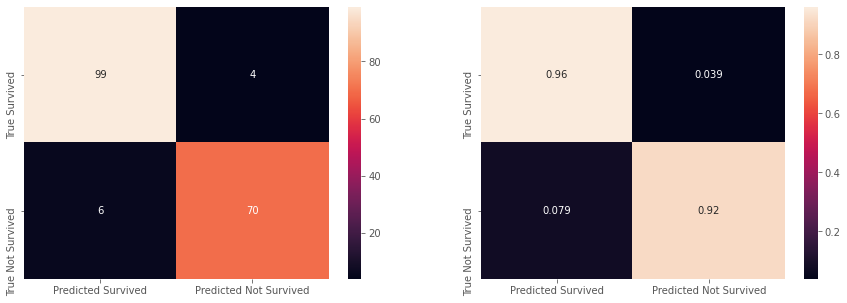

In [189]:
model_AdaBoost(X_test, y_test,1,600,1)

In [156]:
def runAda(X_train, y_train,m,ne,lr):
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=m),n_estimators = ne,learning_rate=lr)  
    clf.fit(X_train, y_train)
    y_pred_random_forest_training_set = clf.predict(X_train)
    acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
    print ("Accuracy: %i %% \n"%acc_random_forest)
    
    class_names = ['Survived', 'Not Survived']
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_pred_random_forest_training_set)
    np.set_printoptions(precision=2)
    
    print ('Confusion Matrix in Numbers')
    print (cnf_matrix)
    print ('')
    
    cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    
    print ('Confusion Matrix in Percentage')
    print (cnf_matrix_percent)
    print ('')
    
    
    print('AdaBoost Classifier Training Metrics: \n Model score: %.4f \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
    (clf.score(X_train, y_train),
     accuracy(y_test, clf.predict(X_test)), 
     precision(y_test, clf.predict(X_test)), 
     recall(y_test, clf.predict(X_test)),
     F1(y_test, clf.predict(X_test))
           )
       )       
    print('---------------------')     
    print ('')    
        
    
    true_class_names = ['True Survived', 'True Not Survived']
    predicted_class_names = ['Predicted Survived', 'Predicted Not Survived']
    
    df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                                 index = true_class_names,
                                 columns = predicted_class_names)
    
    df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                         index = true_class_names,
                                         columns = predicted_class_names)
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(121)
    sns.heatmap(df_cnf_matrix, annot=True, fmt='d')
    
    plt.subplot(122)
    sns.heatmap(df_cnf_matrix_percent, annot=True)

# Predicting if a passenger survives

In [168]:
adaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                               n_estimators=600,
                               learning_rate=1.9)   
ada_model = adaBoost.fit(X_train, y_train)

def predict_fate(name,passenger_data):
    result = adaBoost.predict(passenger_data) 
    proba = adaBoost.predict_proba(passenger_data)[:, 1]
    if proba <= 0.5:
        print(f'Unfortunately, {name} will not survive.')
    else:
        print(f'{name} has a {proba} probability of survival.')
    print(f'probability: {adaBoost.predict_proba(passenger_data)}')

In [169]:
new_input1 = [[1,1,0,0,30,1,2]]
# 'Pclass'   = 1
# 'Sex'      = 1
# 'SibSp'    = 0
# 'Parch'    = 0 
# 'Fare'     = 30 
# 'Embarked' = 1
# 'AgeGroup' = 2



predict_fate('Mike',new_input1)   

Unfortunately, Mike will not survive.
probability: [[0.5 0.5]]


In [170]:
new_input2 =[[1,0,0,3,500,1,1]]

# 'Pclass'   = 0
# 'Sex'      = 0
# 'SibSp'    = 0
# 'Parch'    = 3 
# 'Fare'     = 480 
# 'Embarked' = 1
# 'AgeGroup' = 2

predict_fate('Lilith',new_input2)  

Lilith has a [0.5] probability of survival.
probability: [[0.5 0.5]]


In [179]:
new_input3 =[[1,0,0,0,500,2,1]]

# 'Pclass'   = 2
# 'Sex'      = 0
# 'SibSp'    = 1
# 'Parch'    = 3 
# 'Fare'     = 60 
# 'Embarked' = 2
# 'AgeGroup' = 1

predict_fate('Lucas',new_input2)  

Lucas has a [0.5] probability of survival.
probability: [[0.5 0.5]]


## Appendix: some further experimentation

In [ ]:
#Create a function within many Machine Learning Models
def models(X_train,Y_train):
  
    #Using Logistic Regression Algorithm to the Training Set
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state = 0)
    log.fit(X_train, Y_train)
    
    #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    knn.fit(X_train, Y_train)

    #Using SVC method of svm class to use Support Vector Machine Algorithm
    from sklearn.svm import SVC
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    svc_lin.fit(X_train, Y_train)

    #Using SVC method of svm class to use Kernel SVM Algorithm
    from sklearn.svm import SVC
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    svc_rbf.fit(X_train, Y_train)

    #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
    from sklearn.naive_bayes import GaussianNB
    gauss = GaussianNB()
    gauss.fit(X_train, Y_train)

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train, Y_train)

    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(X_train, Y_train)

    #Using ADABOOST
    from sklearn.ensemble import AdaBoostClassifier
    adaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
    adaBoost.fit(X_train, Y_train)
    
    #Using XGBoost
    from sklearn.ensemble import AdaBoostClassifier
    xgboost = xgb.XGBClassifier()
    '''
    xgboost = xgb.XGBClassifier(silent=False, 
                        scale_pos_weight=1,
                        learning_rate=0.01,  
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        n_estimators=500, 
                        reg_alpha = 0.3,
                        max_depth=4, 
                        gamma=10)    
      
    '''  
      
    xgboost.fit(X_train, Y_train)    


    #print model accuracy on the training data.
    #print('[0]Logistic Regression Training Accuracy:', log.score(X_train, Y_train))
    print('[0]Logistic Regression Training Metrics: \n Model score: %.4f \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
    (log.score(X_train, Y_train),
     accuracy(Y_test, log.predict(X_test)), 
     precision(Y_test, log.predict(X_test)), 
     recall(Y_test, log.predict(X_test)),
     F1(Y_test, log.predict(X_test))
           )
       )       
    print(' ')    
    
    print('---------------------')
    #print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_train, Y_train))
    print('[1]K Nearest Neighbor Training Metrics: \n Model score: %.4f \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
    (knn.score(X_train, Y_train),
     accuracy(Y_test, knn.predict(X_test)), 
     precision(Y_test, knn.predict(X_test)), 
     recall(Y_test, knn.predict(X_test)),
     F1(Y_test, knn.predict(X_test))
           )
       )       
    print('---------------------')
    
    
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train, Y_train))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train, Y_train))
    print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train, Y_train))
    print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_train, Y_train))
    print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_train, Y_train))
    print(' ')    
    
    print('---------------------')    
    #print('[7]AdaBoost Classifier Training Accuracy:', adaBoost.score(X_train, Y_train))   
    print('[7]AdaBoost Classifier Training Metrics: \n Model score: %.4f \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
    (adaBoost.score(X_train, Y_train),
     accuracy(Y_test, adaBoost.predict(X_test)), 
     precision(Y_test, adaBoost.predict(X_test)), 
     recall(Y_test, adaBoost.predict(X_test)),
     F1(Y_test, adaBoost.predict(X_test))
           )
       )       
    print('---------------------')    
    
    
    
    print('[8]XGBoost Classifier Training Accuracy:', xgboost.score(X_train, Y_train)) 
    


    return log, knn, svc_lin, svc_rbf, gauss, tree, forest, adaBoost, xgboost

In [ ]:
#Get and train all of the models
model = models(X_train,Y_train)

## Ensembling tests

In [ ]:
knn = KNeighborsClassifier()
ada = AdaBoostClassifier()
rnf = RandomForestClassifier()

model_lst = [('knn', knn),
            ('ada', ada),
            ('rnf', rnf)]
for model in model_lst:
    curr_name, curr_model = model
    curr_model.fit(X_train, y_train)
    curr_score = curr_model.score(X_test, y_test)
    
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators=model_lst,
                      voting='hard',
                      weights=None)
vc.fit(X_train,y_train)
vc.score(X_test, y_test)   

## Predicting with Ensemble

In [202]:

vc = VotingClassifier(estimators=model_lst,
                      voting='hard',
                      weights=None)
vc_model = adaBoost.fit(X_train, y_train)

def predict_fate_en(name,passenger_data):
    result = vc_model.predict(passenger_data) 
    proba = vc_model.predict_proba(passenger_data)[:, 1]
    if proba <= 0.5:
        print(f'Unfortunately, {name} will not survive.')
    else:
        print(f'{name} has a {proba} probability of survival.')
    print(f'probability: {vc_model.predict_proba(passenger_data)}')

In [203]:
new_input1 = [[1,1,0,0,30,1,2]]
# 'Pclass'   = 1
# 'Sex'      = 1
# 'SibSp'    = 0
# 'Parch'    = 0 
# 'Fare'     = 30 
# 'Embarked' = 1
# 'AgeGroup' = 2



predict_fate_en('Mike',new_input1)  

Unfortunately, Mike will not survive.
probability: [[0.5 0.5]]


## Running RandomForest

Accuracy: 93 % 

Confusion Matrix in Numbers
[[314  11]
 [ 26 183]]

Confusion Matrix in Percentage
[[0.97 0.03]
 [0.12 0.88]]

Rendom Forest Classifier Training Metrics: 
 Model score: 0.9307 
 Accuracy: 0.7765 
 Precision: 0.6986 
 Recall: 0.7391 
 F1: 0.7183
---------------------


<AxesSubplot:>

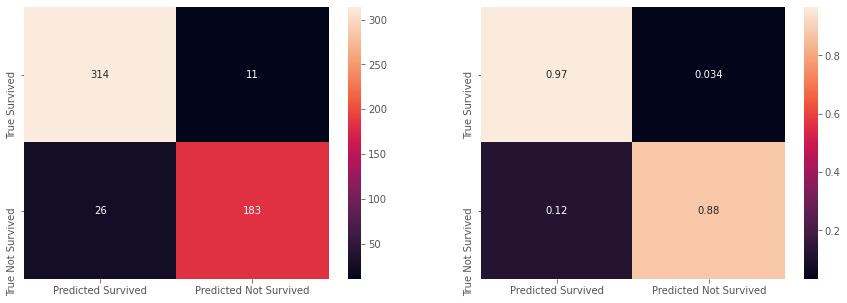

In [131]:

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred_random_forest_training_set = clf.predict(X_train)
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
print ("Accuracy: %i %% \n"%acc_random_forest)

class_names = ['Survived', 'Not Survived']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred_random_forest_training_set)
np.set_printoptions(precision=2)

print ('Confusion Matrix in Numbers')
print (cnf_matrix)
print ('')

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

print ('Confusion Matrix in Percentage')
print (cnf_matrix_percent)
print ('')


print('Rendom Forest Classifier Training Metrics: \n Model score: %.4f \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
(clf.score(X_train, y_train),
 accuracy(y_test, clf.predict(X_test)), 
 precision(y_test, clf.predict(X_test)), 
 recall(y_test, clf.predict(X_test)),
 F1(y_test, clf.predict(X_test))
       )
   )       
print('---------------------')      
    

true_class_names = ['True Survived', 'True Not Survived']
predicted_class_names = ['Predicted Survived', 'Predicted Not Survived']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True)

In [180]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators':  [50, 100, 200, 300, 500, 800],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]
    }
gs_ab = GridSearchCV(AdaBoostClassifier(),param_grid=param_grid)
gs_ab.fit(X_train,y_train)
adboost_model = gs_ab.fit(X_train,y_train)
y_pred = gs_ab.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0])

In [181]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",adboost_model.best_estimator_)
print("\n The best score across ALL searched params:\n",adboost_model.best_score_)
print("\n The best parameters across ALL searched params:\n",adboost_model.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 AdaBoostClassifier(learning_rate=1.3, n_estimators=300)

 The best score across ALL searched params:
 0.8108270146358667

 The best parameters across ALL searched params:
 {'learning_rate': 1.3, 'n_estimators': 300}



## Using GridSearchCV to optimize randomforest

In [ ]:

from sklearn.model_selection import GridSearchCV
n_estimators = [50, 100, 200, 300, 500, 800]
max_depth = [1,2,3,4,5,6,7,8,9,10, 20, 40, 80, 100]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 100]
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(clf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",bestF.best_estimator_)
print("\n The best score across ALL searched params:\n",bestF.best_score_)
print("\n The best parameters across ALL searched params:\n",bestF.best_params_)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

clf = RandomForestClassifier(max_depth= 6,
                             min_samples_leaf=1,
                             min_samples_split=15,
                             n_estimators=100)
clf.fit(X_train, y_train)
y_pred_random_forest_training_set = clf.predict(X_train)
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
print ("Accuracy: %i %% \n"%acc_random_forest)

class_names = ['Survived', 'Not Survived']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred_random_forest_training_set)
np.set_printoptions(precision=2)

print ('Confusion Matrix in Numbers')
print (cnf_matrix)
print ('')

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

print ('Confusion Matrix in Percentage')
print (cnf_matrix_percent)
print ('')


print('Rendom Forest Classifier Training Metrics: \n Model score: %.4f \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
(clf.score(X_train, y_train),
 accuracy(y_test, clf.predict(X_test)), 
 precision(y_test, clf.predict(X_test)), 
 recall(y_test, clf.predict(X_test)),
 F1(y_test, clf.predict(X_test))
       )
   )       
print('---------------------')      
    

true_class_names = ['True Survived', 'True Not Survived']
predicted_class_names = ['Predicted Survived', 'Predicted Not Survived']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True)


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

clf = RandomForestClassifier(random_state=1,
                             max_depth= 6,
                             min_samples_leaf=2,
                             min_samples_split=2,
                             n_estimators=50)
clf.fit(X_train, y_train)
y_pred_random_forest_training_set = clf.predict(X_train)
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
print ("Accuracy: %i %% \n"%acc_random_forest)

class_names = ['Survived', 'Not Survived']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred_random_forest_training_set)
np.set_printoptions(precision=2)

print ('Confusion Matrix in Numbers')
print (cnf_matrix)
print ('')

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

print ('Confusion Matrix in Percentage')
print (cnf_matrix_percent)
print ('')


print('Rendom Forest Classifier Training Metrics: \n Model score: %.4f \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
(clf.score(X_train, y_train),
 accuracy(y_test, clf.predict(X_test)), 
 precision(y_test, clf.predict(X_test)), 
 recall(y_test, clf.predict(X_test)),
 F1(y_test, clf.predict(X_test))
       )
   )       
print('---------------------')      
    

true_class_names = ['True Survived', 'True Not Survived']
predicted_class_names = ['Predicted Survived', 'Predicted Not Survived']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True)

-------------------------

## CART Feature Importance

In [ ]:
forest = model[7]
importance = forest.feature_importances_
#summarize feature importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)

plt.show() 

In [ ]:
df_training.columns

In [ ]:
#Get the importance of the features
forest = model[8]
importances = pd.DataFrame({'feature':df_training.iloc[:,0:7].columns,'importance':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances